In [1]:
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *

DEVICE:  cpu


In [3]:
T=30

In [4]:
etfs = ['XLB','XLE','XLF','XLI','XLP','XLV','XLY','XLU']
metrics = ["ATR","SD_Log_Close"]
start = '2001-01-01'
end = '2022-01-01'
start_t = '2023-01-01'
end_t = '2024-01-05'
models = {}
lrs = [0]

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLB
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 122 shares for $9935.68
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size([1, 30]) t

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLB
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLE
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 116 shares for $9949.32
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size([1, 30]) t

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLE
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLF


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLF
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 280 shares for $9996.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size([1, 30]) to

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLF


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLF
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLI


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLI
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 98 shares for $9904.859999999999
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size([

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLI


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLI
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 98 shares for $9904.859999999999
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1,

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLP


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLP
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 138 shares for $9981.539999999999
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size(

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLP


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLP
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLV


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLV
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 78 shares for $9970.74
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size([1, 30]) to

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLV


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLV
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 79 shares for $9998.24
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 39th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 40th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLY


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLY
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 68 shares for $9897.400000000001
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size([

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLY


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLY
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 68 shares for $9897.400000000001
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1,

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLU


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLU
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 30th day, Bought 151 shares for $9944.86
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 31th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 32th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 33th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 34th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 35th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 36th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 37th day, Bought 0 shares for $0.0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
On the 38th day, Bought 0 shares for $0.0
torch.Size([1, 30]) t

[*********************100%***********************]  1 of 1 completed


read  5284  lines of data for ticker:  XLU


[*********************100%***********************]  1 of 1 completed


read  253  lines of data for ticker:  XLU
Number of neg. ATR: 0
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([1, 31])
torch.Size([1, 30]) torch.Size([1, 1])
torch.Size([

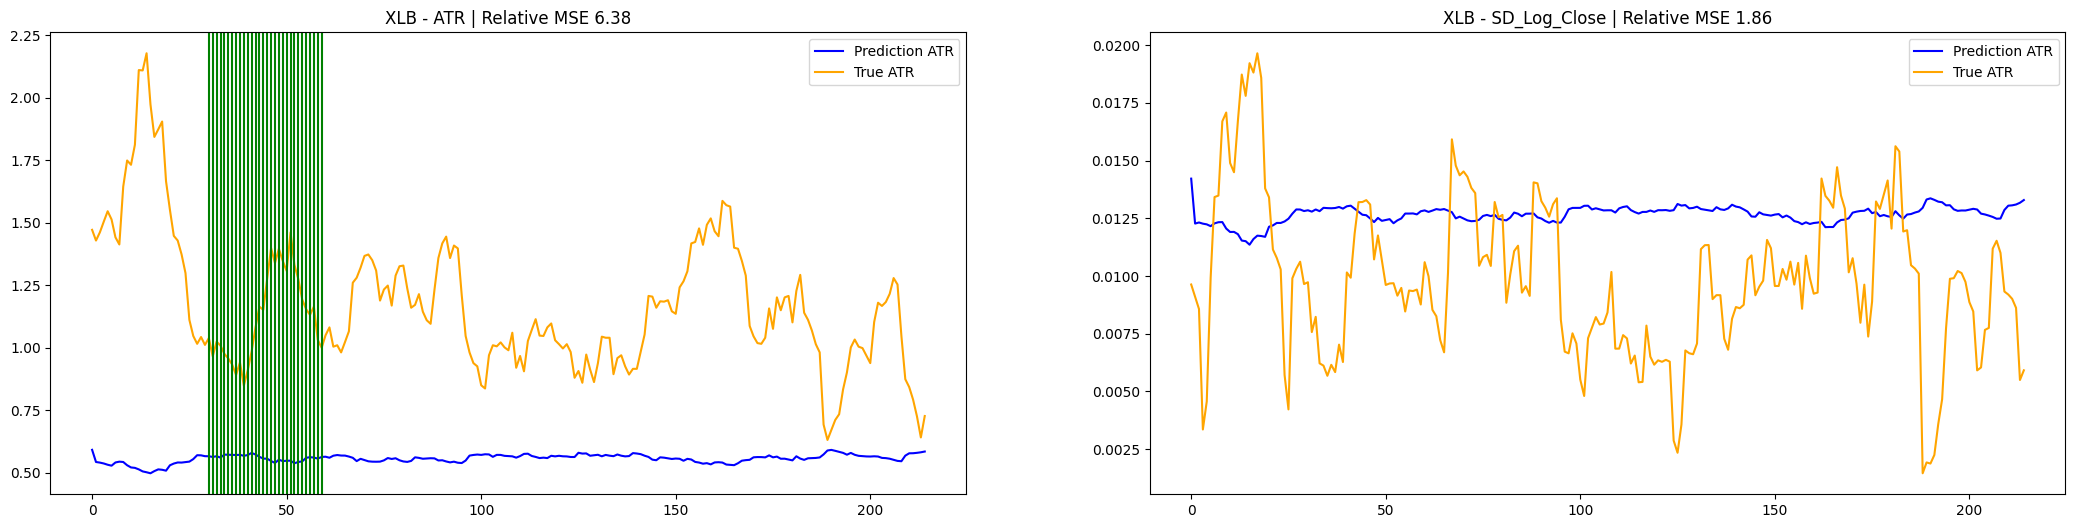

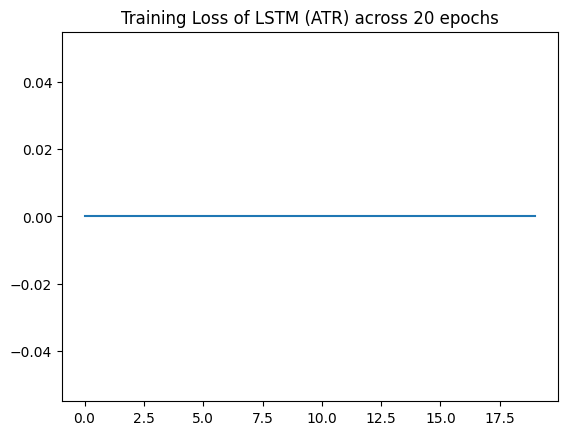

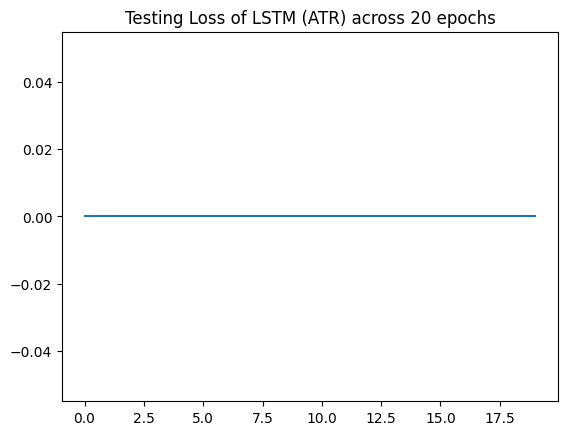

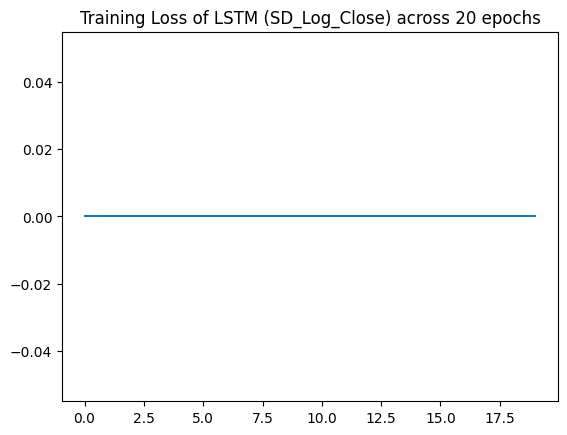

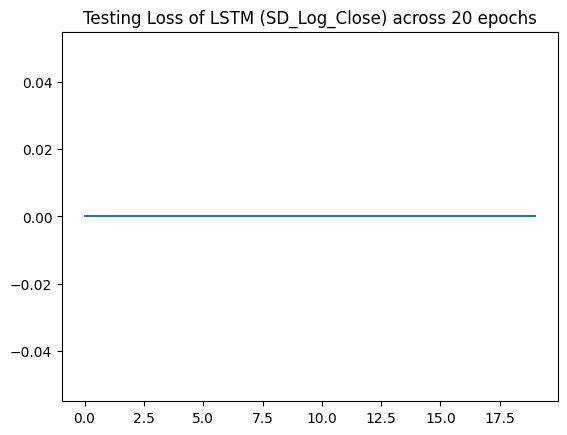

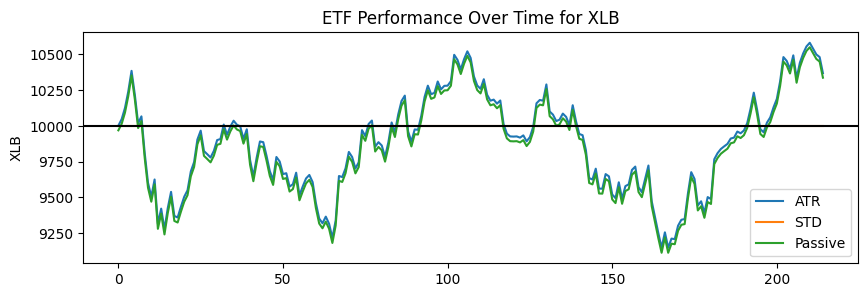

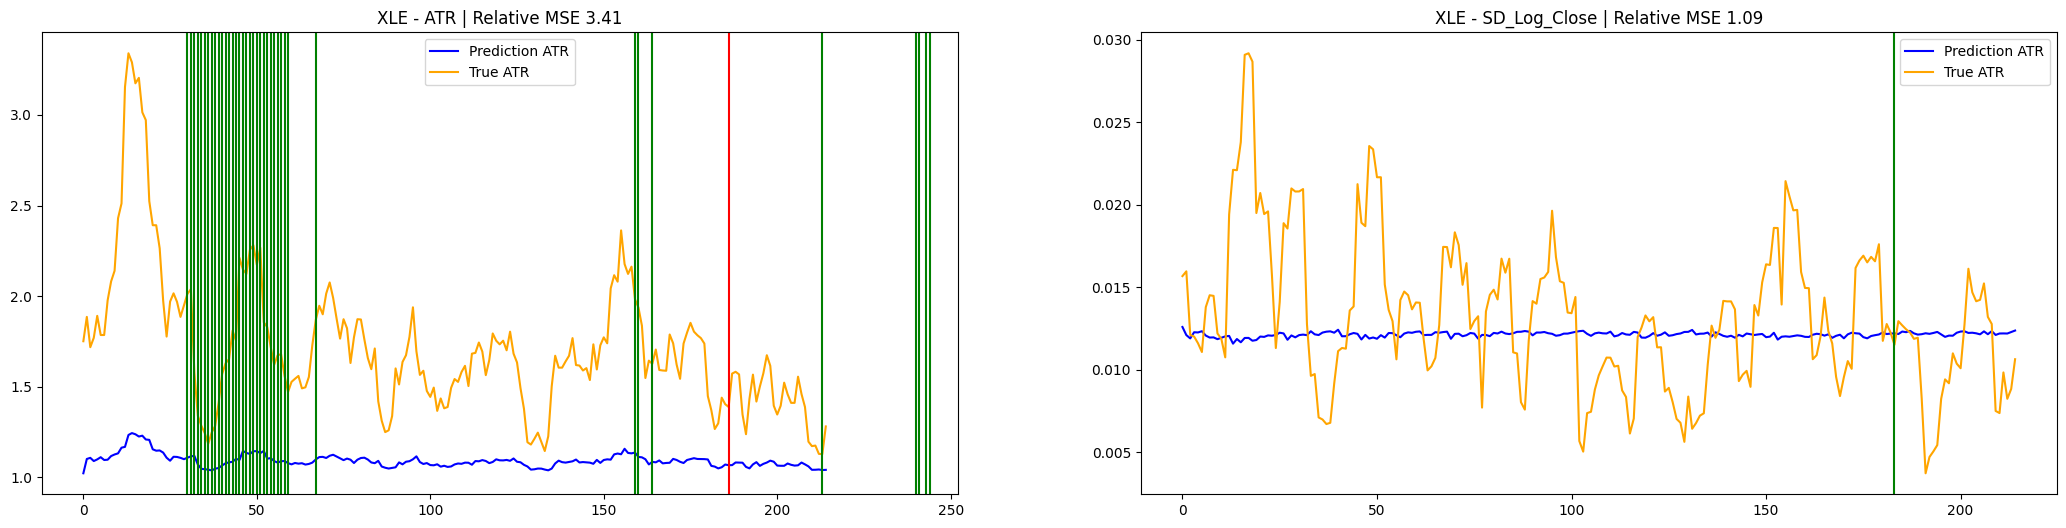

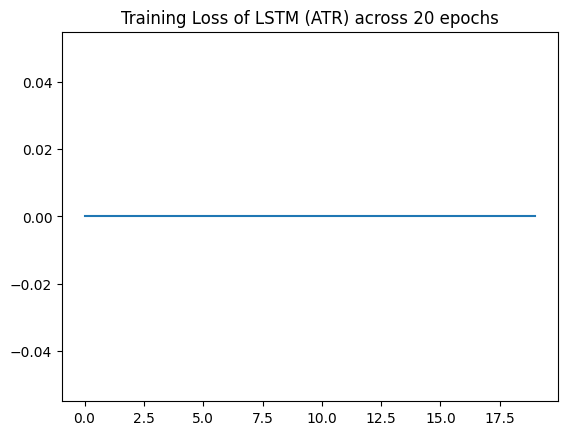

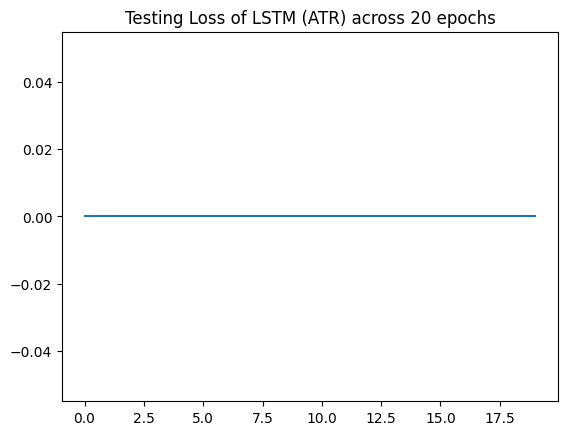

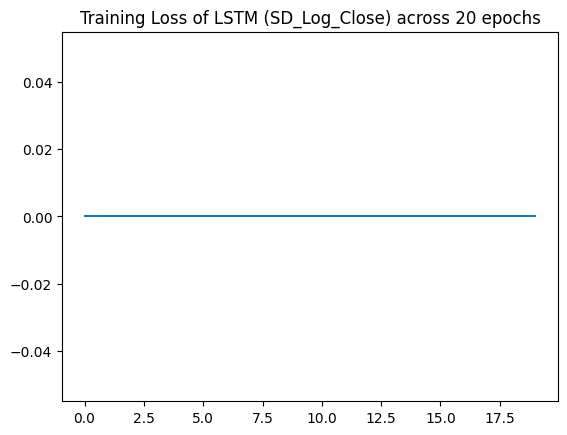

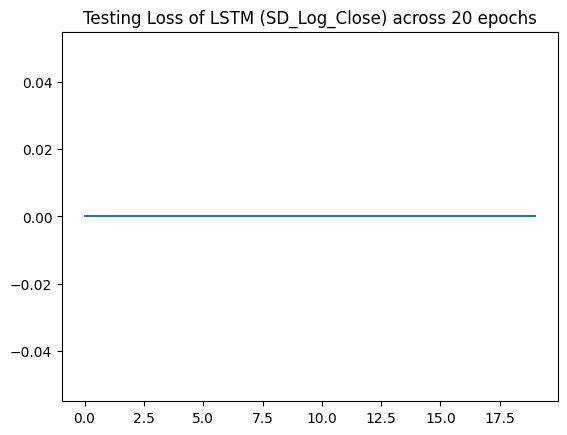

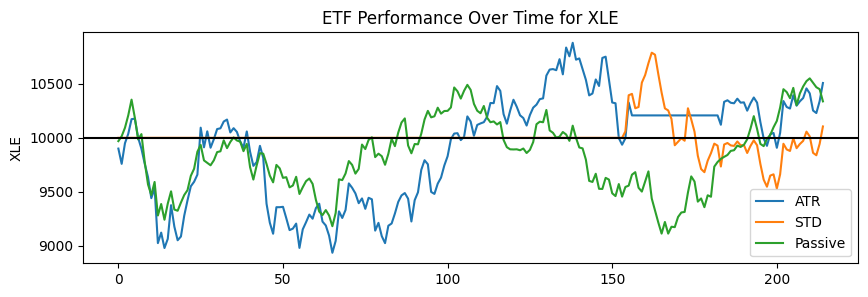

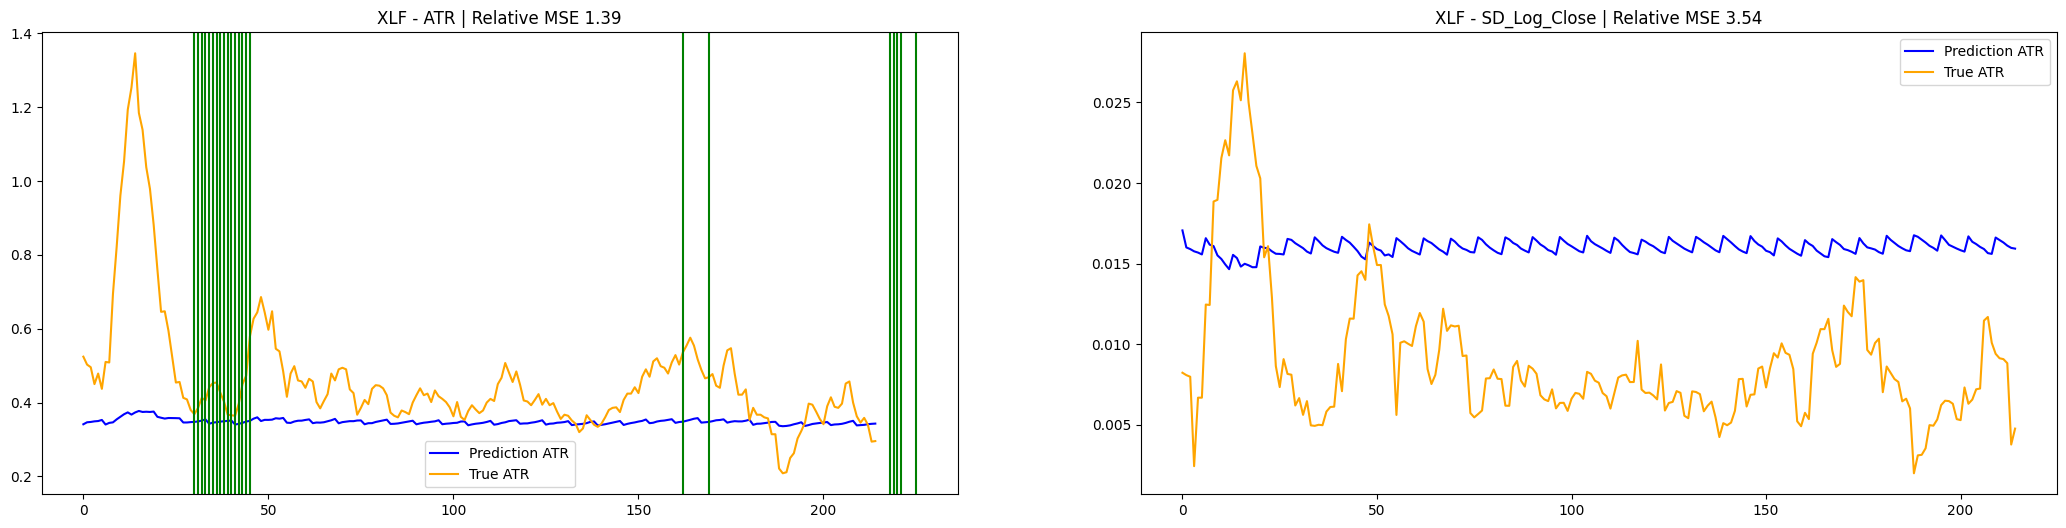

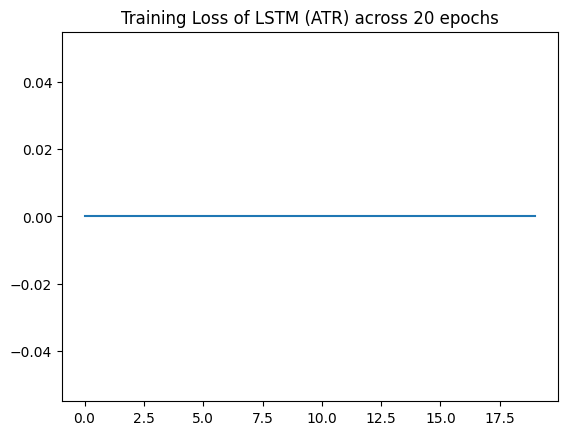

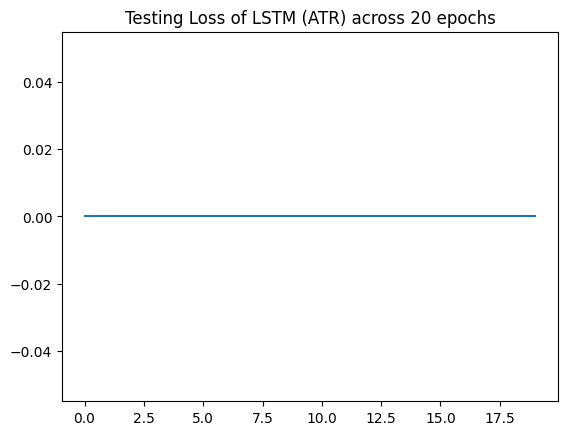

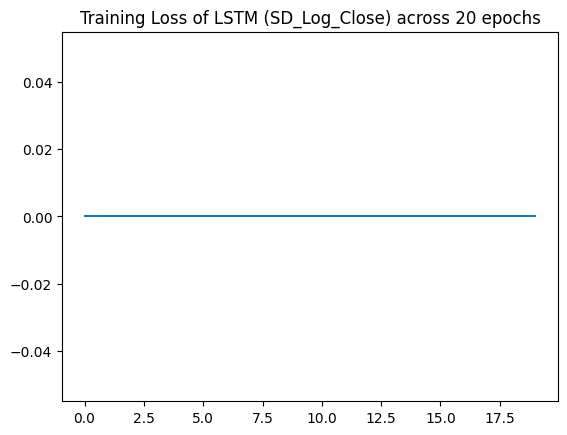

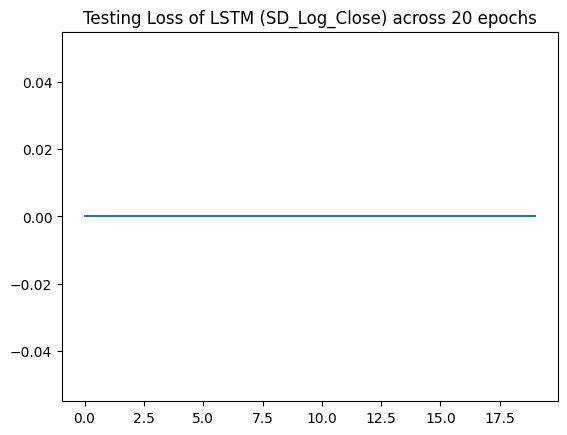

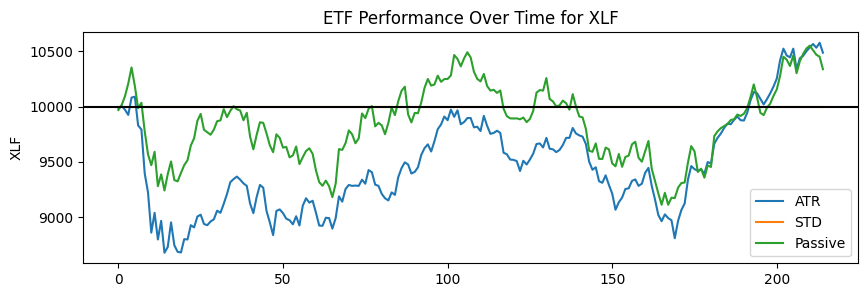

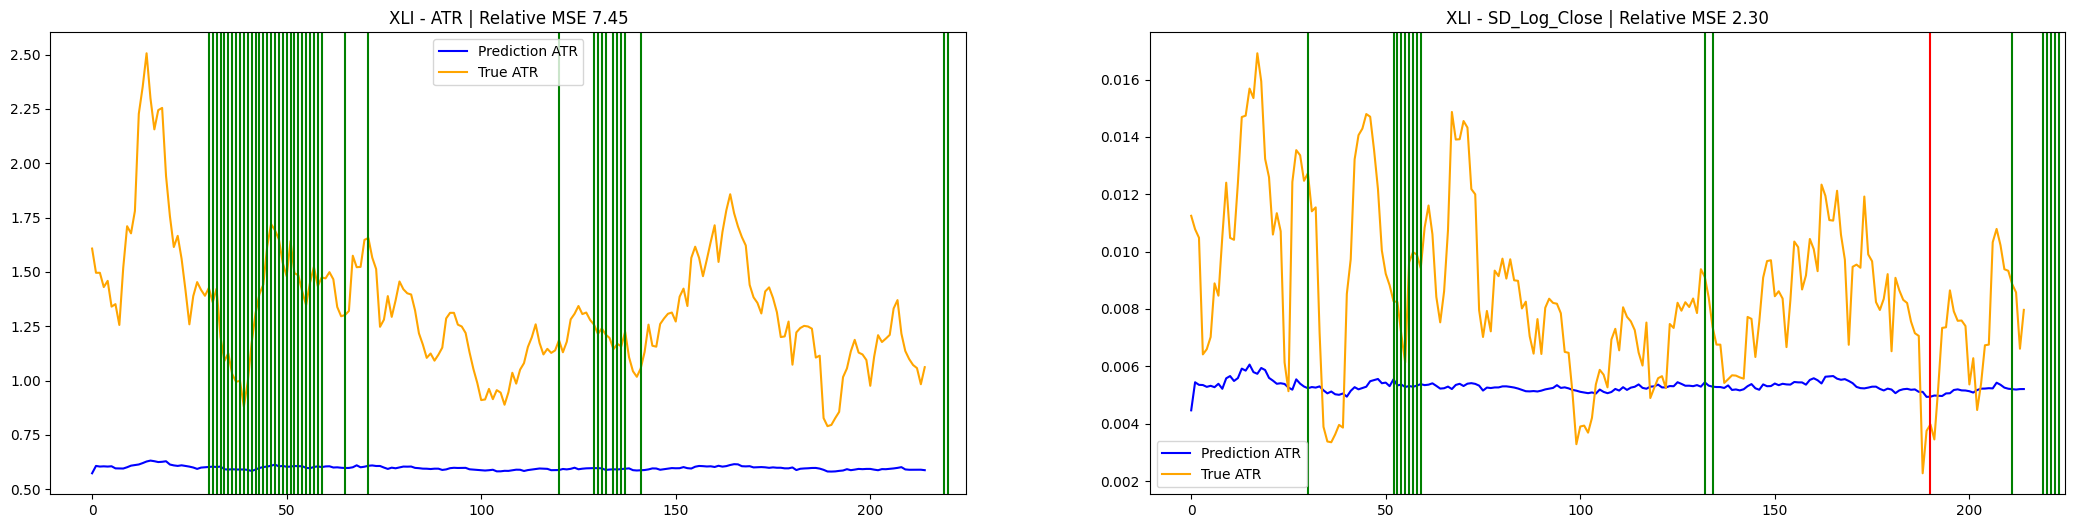

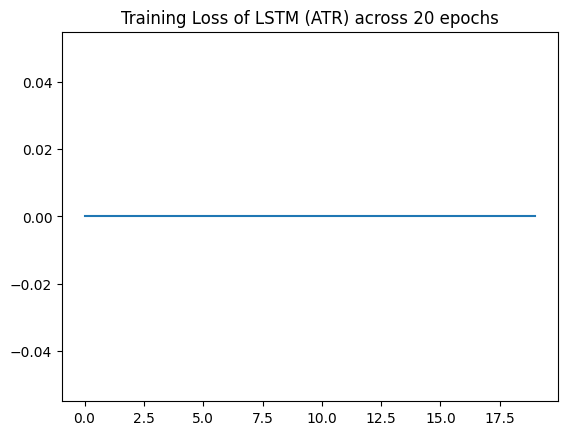

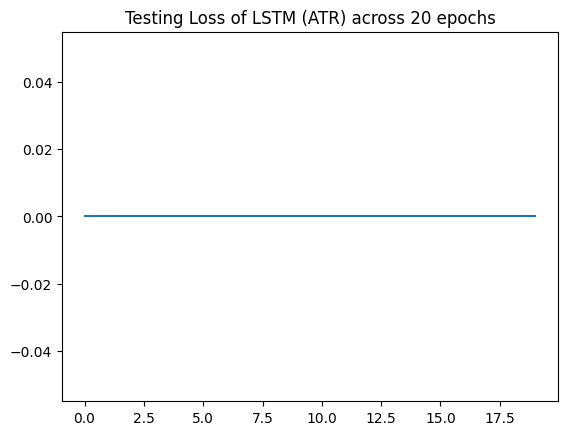

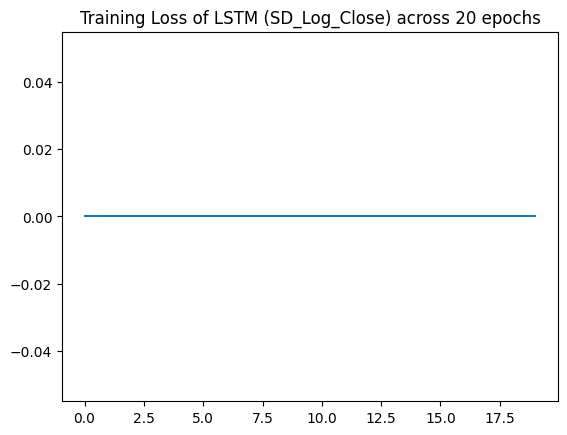

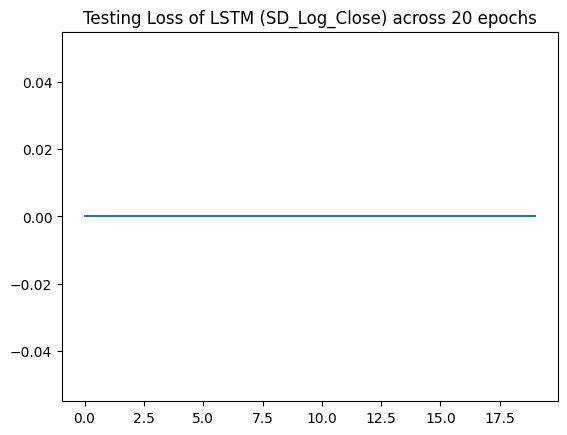

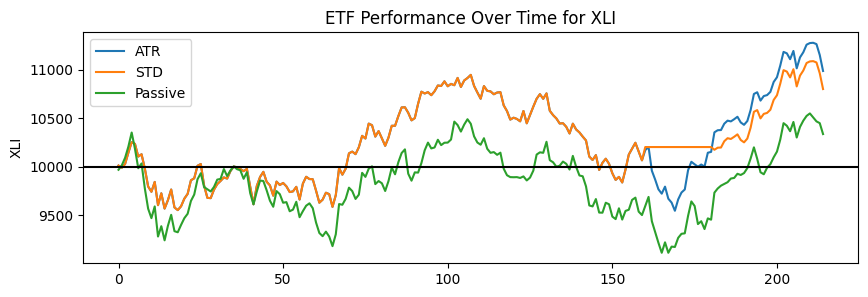

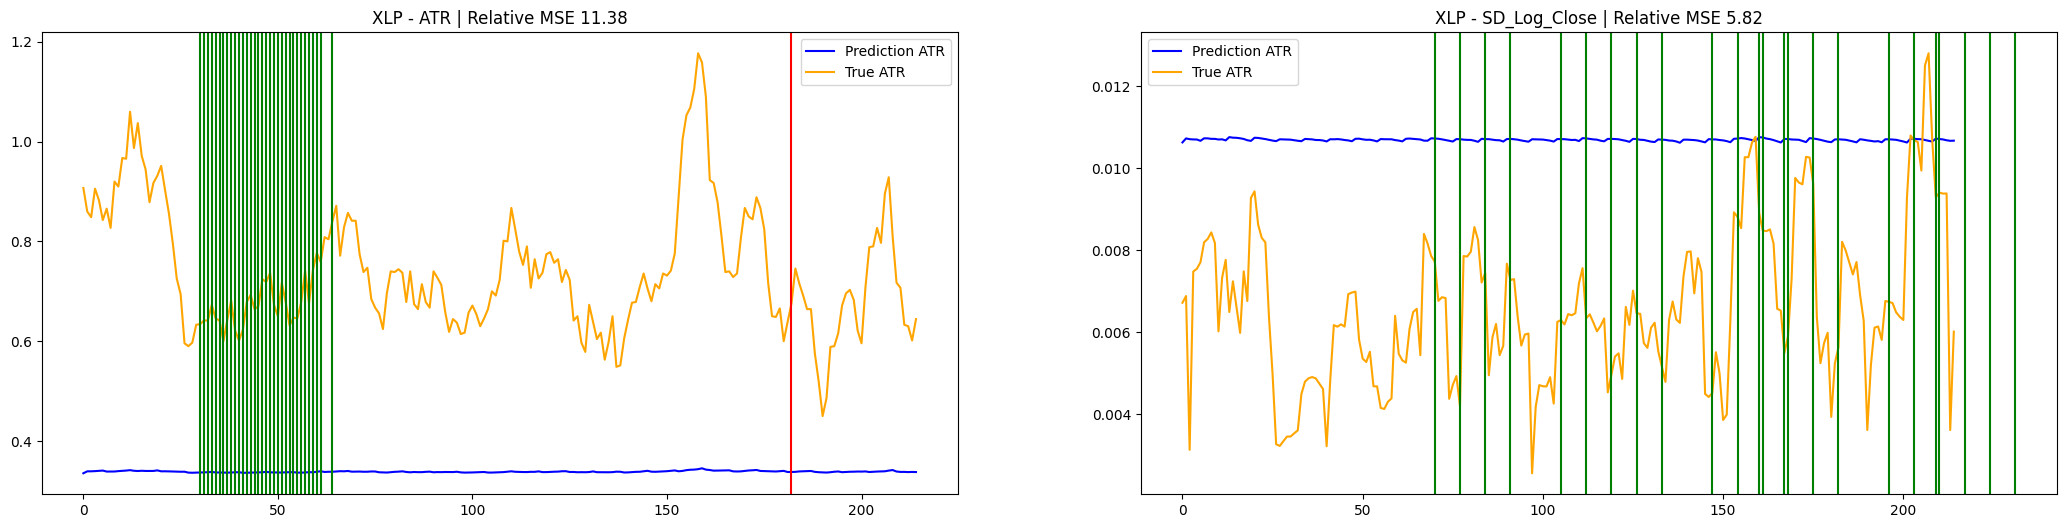

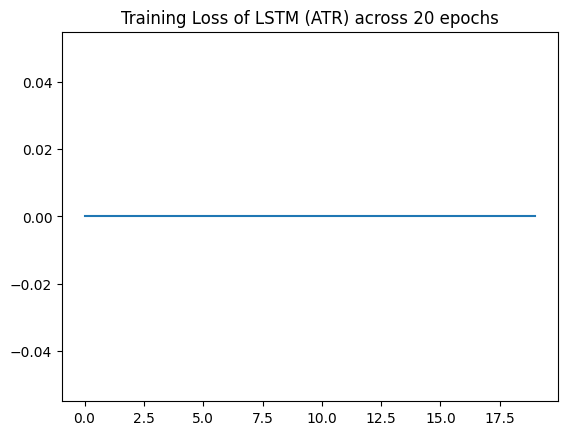

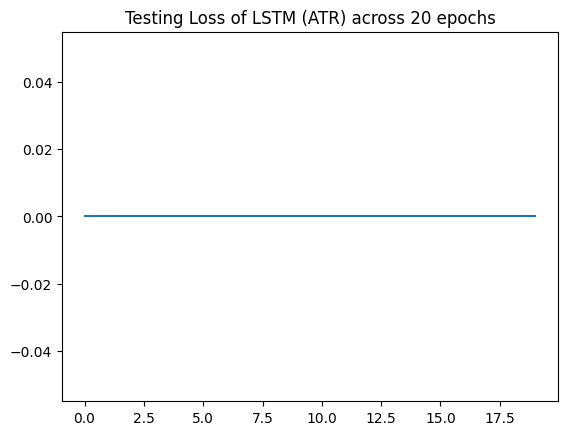

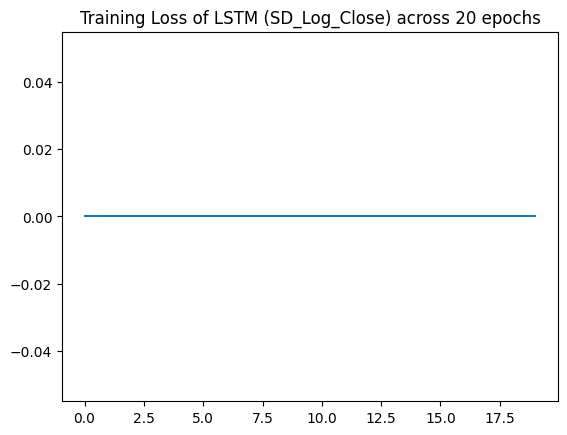

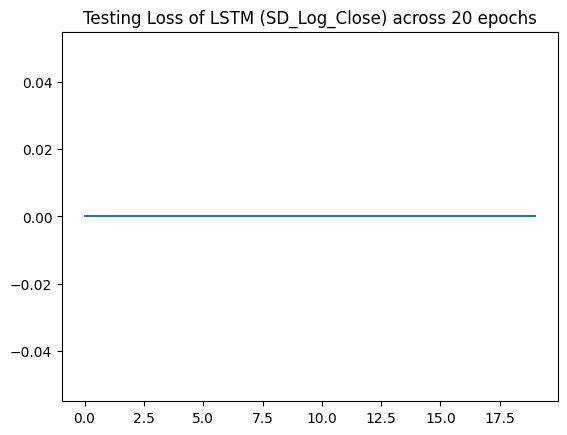

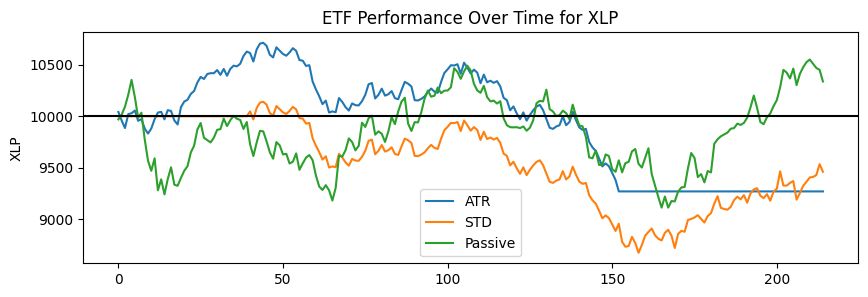

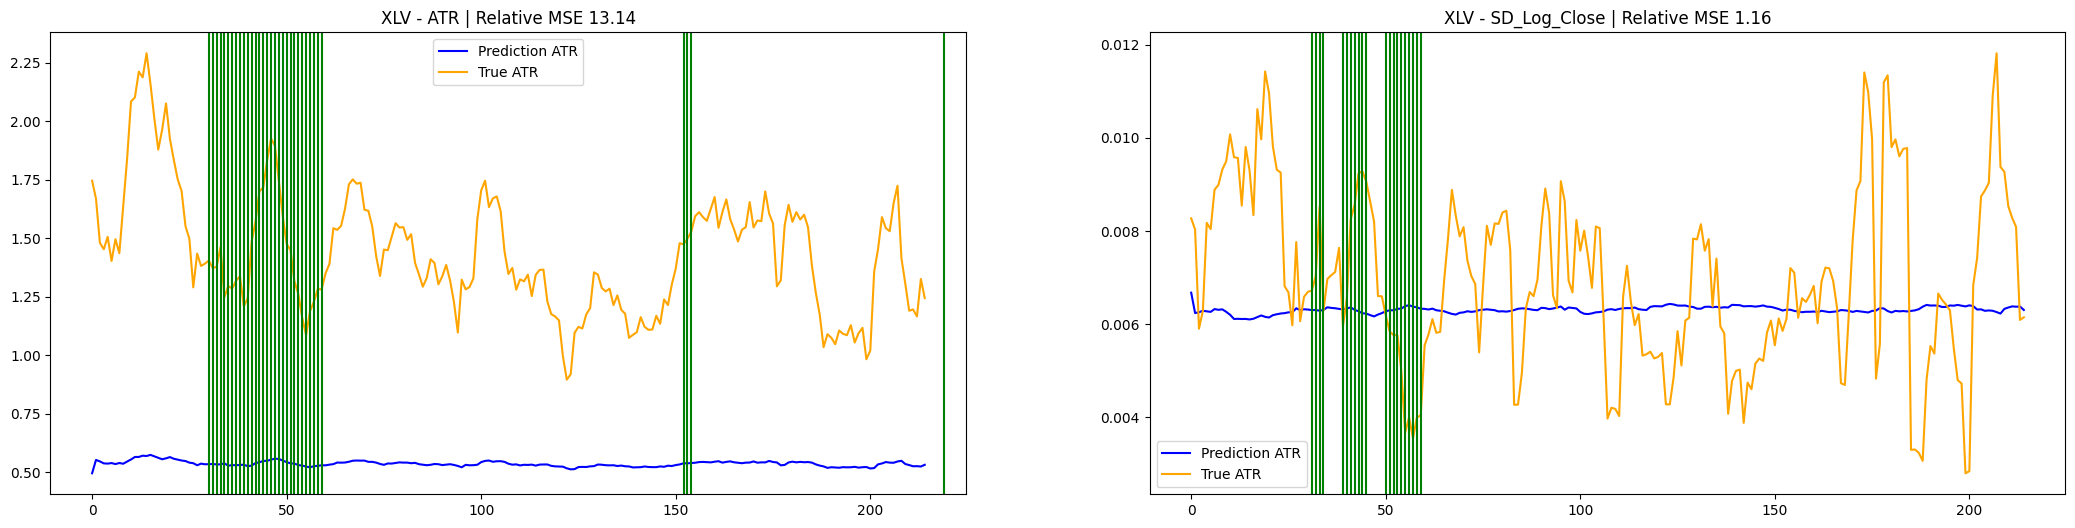

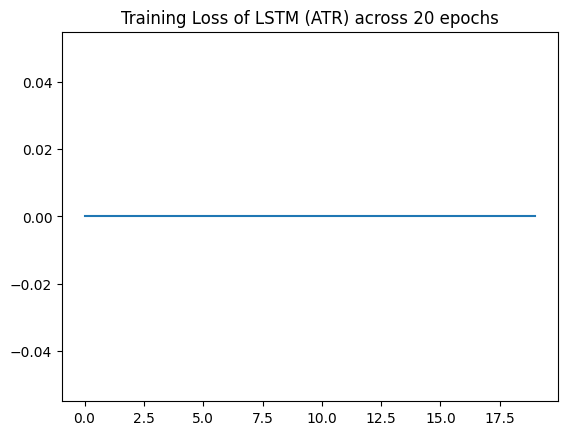

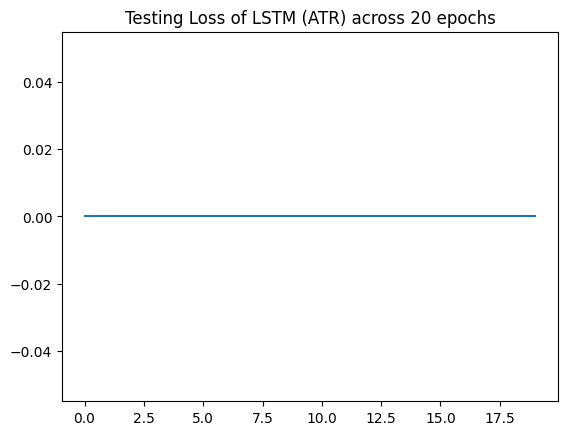

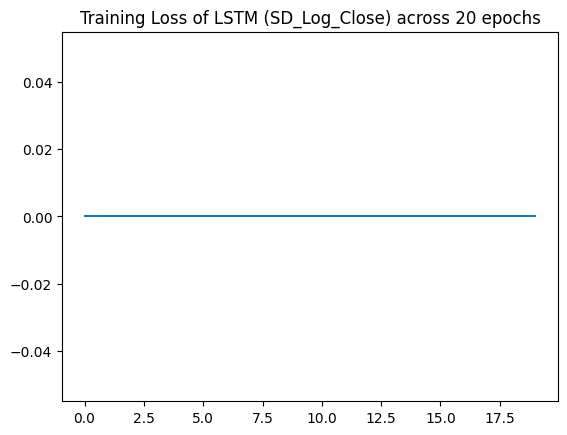

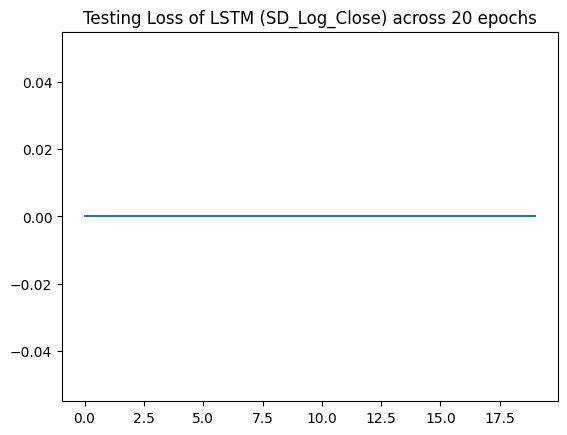

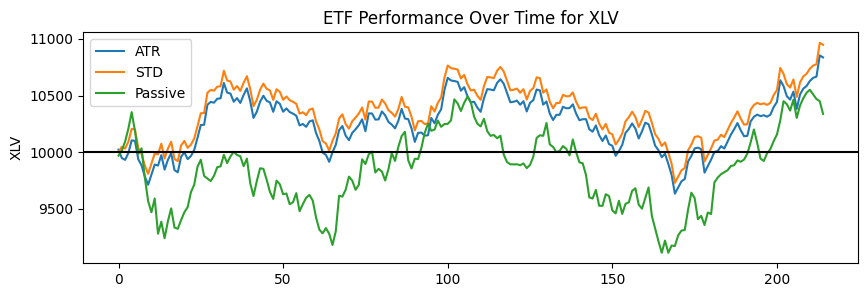

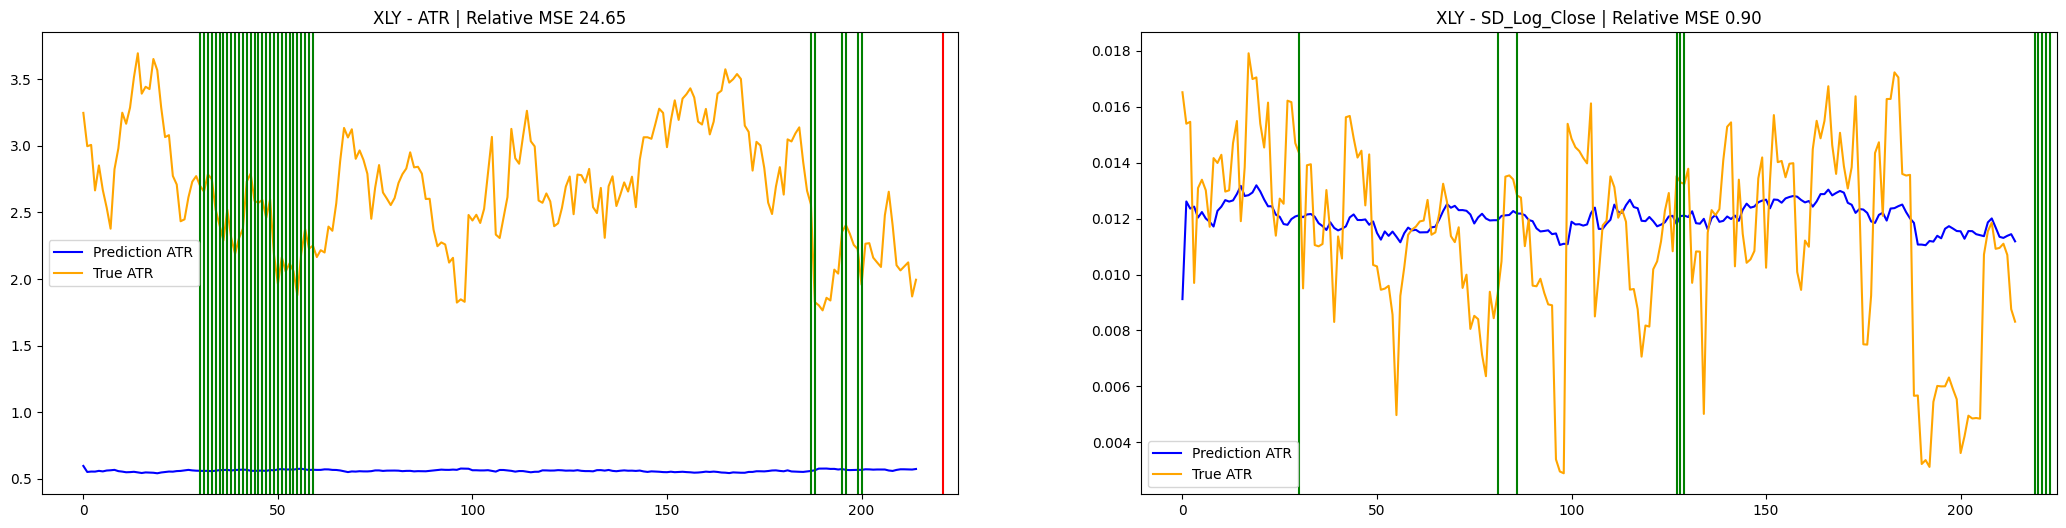

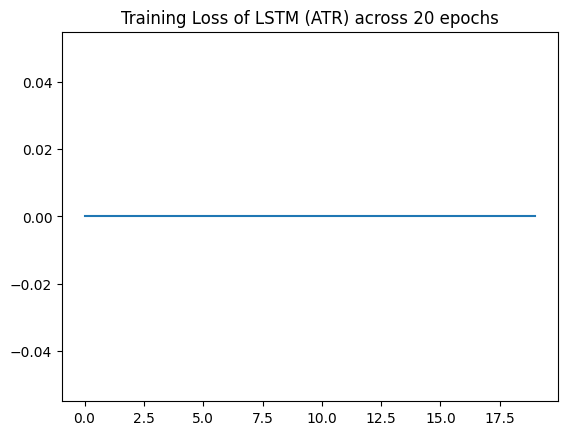

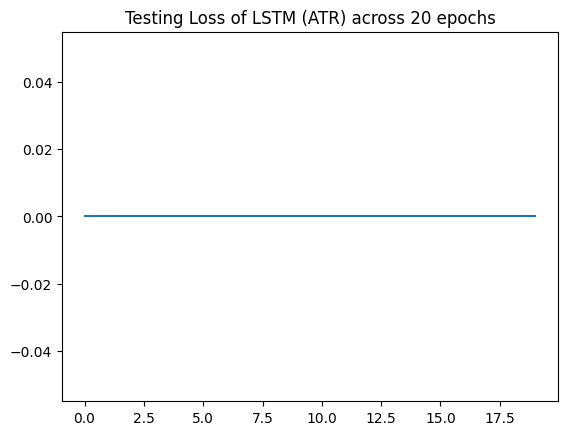

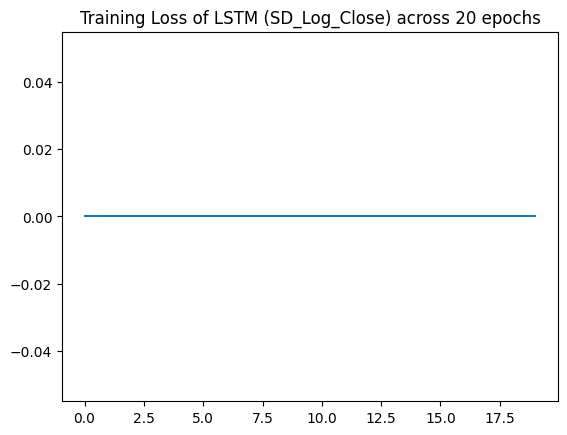

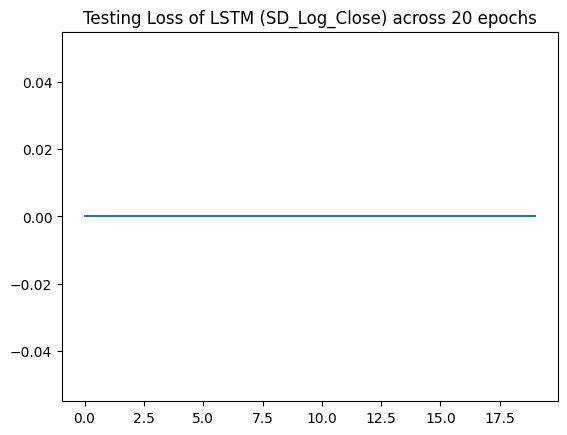

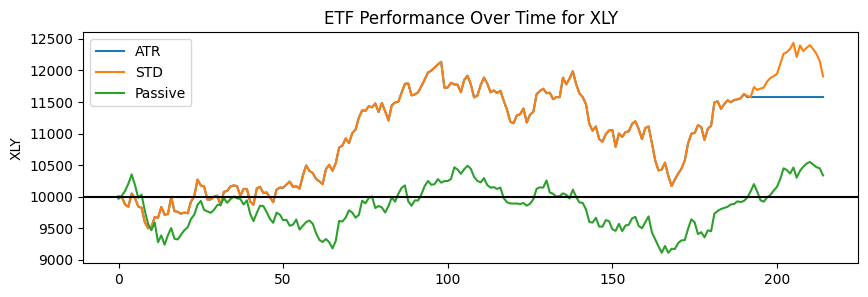

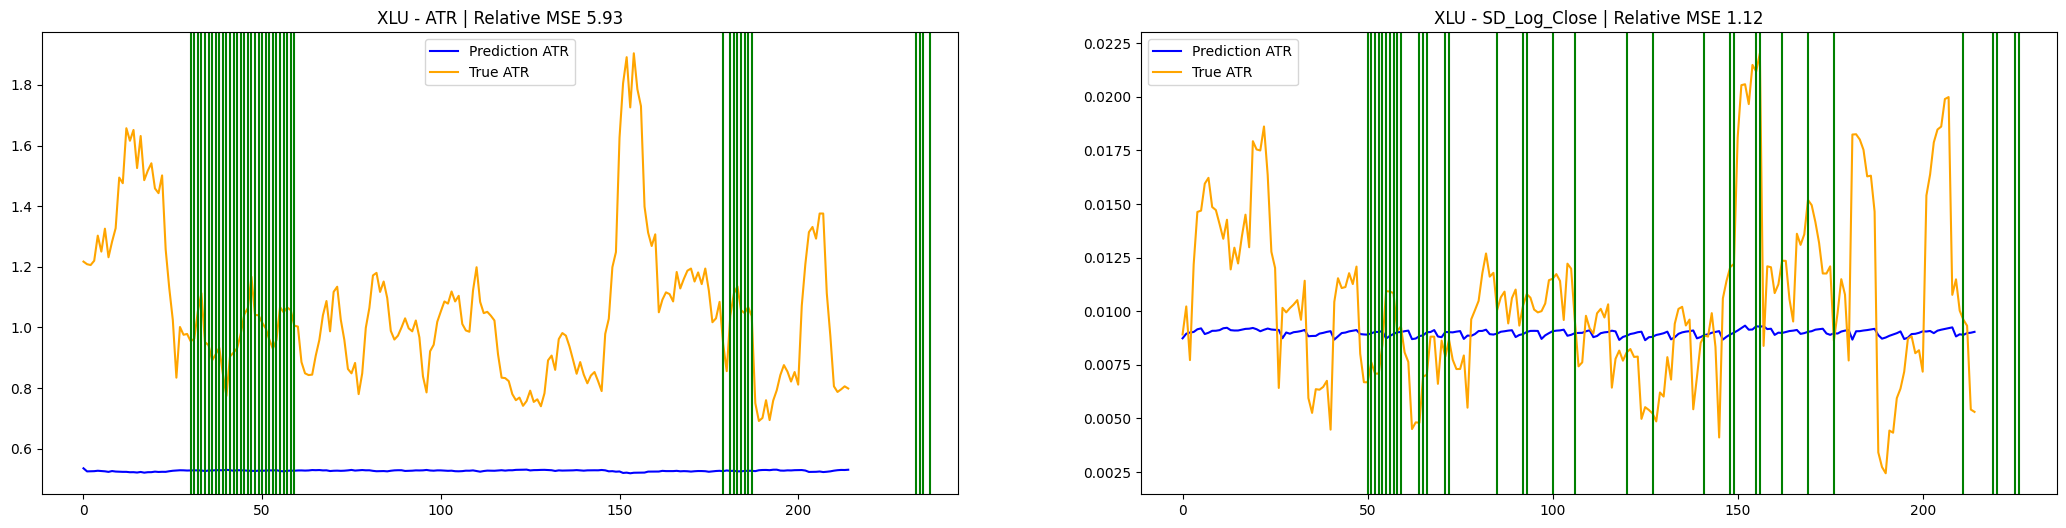

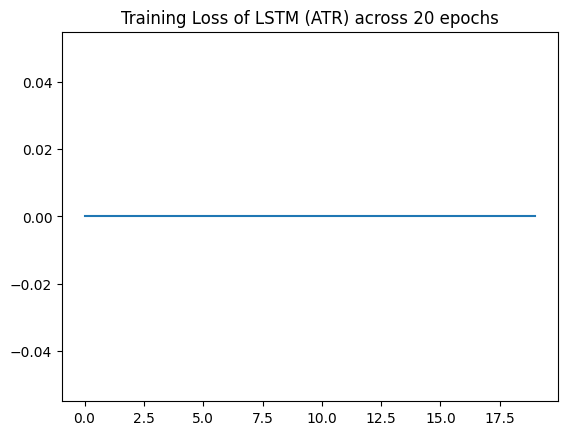

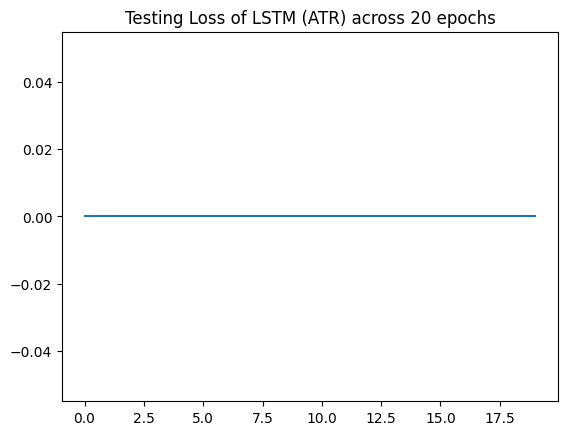

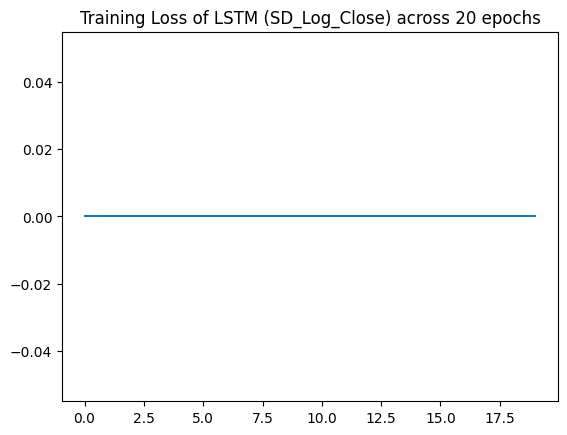

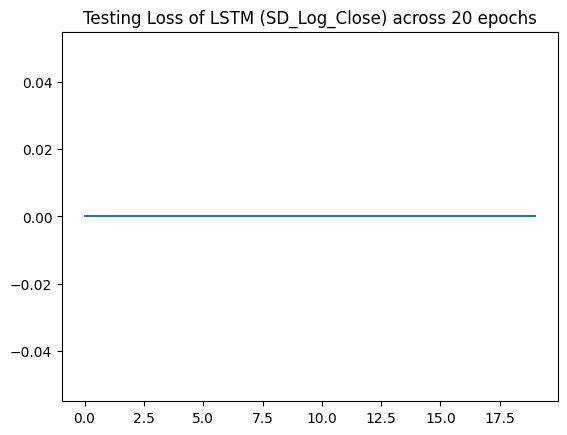

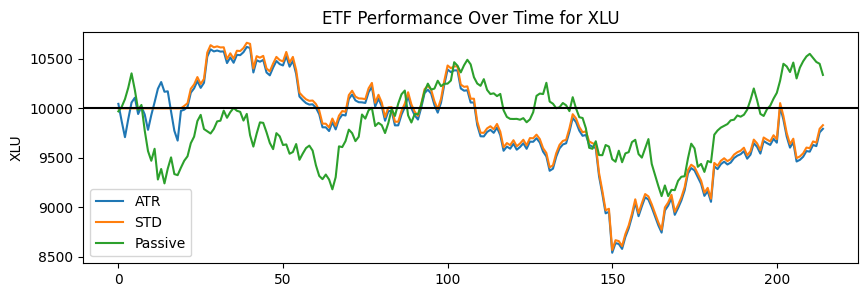

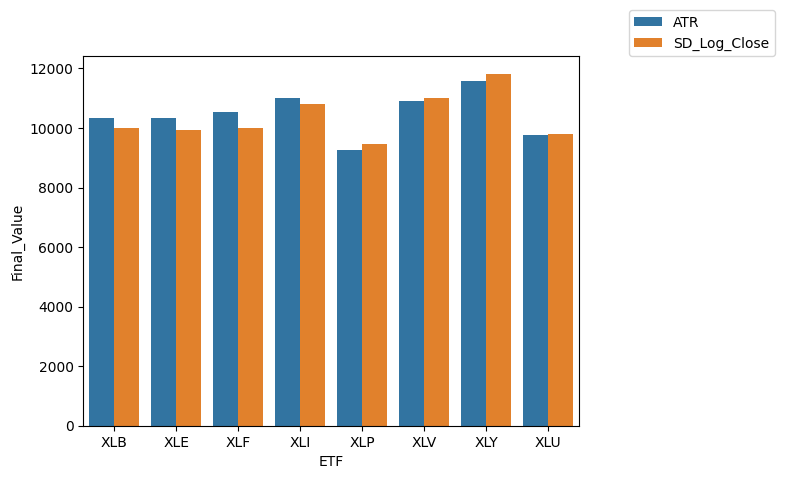

In [5]:
num=1
for file in os.listdir():
    if "runtest" in file:
        num+=1
os.mkdir(f'runtest_{num}')
for etf in etfs:
    os.mkdir(f'runtest_{num}/{etf}')
for lr in lrs:
    results = pd.DataFrame({"ETF":[],"Metric":[],"Final_Value":[],"Passive_Potential":[]})
    money_df_std = pd.DataFrame()
    money_df_atr = pd.DataFrame()
    money_df_passive = pd.DataFrame()
    for j,etf in enumerate(etfs):
        fig,ax = plt.subplots(1,len(metrics),figsize=(26,6))
        for i,metric in enumerate(metrics):
            scaler = StandardScaler()
            df = get_cleaned_df(etf,start,end)
            #print(df)
            model,fig_tr,fig_te = get_trained_model(df,scaler,metric=metric)
            fig_tr.savefig(f'runtest_{num}/{etf}/training_results_{metric}')
            fig_te.savefig(f'runtest_{num}/{etf}/testing_results_{metric}')
            df_test = get_cleaned_df(etf,start_t,end_t)
            print("Number of neg. ATR:",len(df_test.loc[[atr<0 for atr in df_test["ATR"]]]))
            ini_cash = 10000
            final_value, money, shares,passive_value,buy_points,sell_points,preds, t_money,p_money = backtest_strategy(df_test,model,scaler,metric,sell_scale=1.7,buy_scale=1.3)
            print(f"{etf} Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
            results.loc[len(results)] = [etf,metric,final_value,passive_value]
            if metric=="ATR":
               money_df_atr[etf] = t_money
            elif metric=="SD_Log_Close":
                money_df_std[etf] = t_money
                money_df_passive[f"{etf}_{metric}_Passive"] = p_money

            real_met = np.array(df_test[metric].iloc[T:len(df_test)-1])
            null_model_score = np.sum((real_met-np.mean(real_met))**2)
            error = np.sum((real_met-preds)**2)/null_model_score

            sns.lineplot(preds,ax=ax[i],label="Prediction ATR",color="Blue")
            sns.lineplot(real_met,ax=ax[i],label = "True ATR",color="Orange")
            for buy in buy_points:
                ax[i].axvline(buy,color="Green")
            for sell in sell_points:
                ax[i].axvline(sell,color="Red")
            ax[i].set_title(f"{etf} - {metric} | Relative MSE {error:.2f}")
            #plt.title(f"Performance of LSTM on {etf}")
            fig.savefig(f'runtest_{num}/{etf}/predictions_lr_{lr}.png')
        
        fig_sim,ax_sim = plt.subplots(figsize=(10,3))
        sns.lineplot(x=range(0, 215), y=money_df_atr[etf], label="ATR",ax=ax_sim)
        sns.lineplot(x=range(0,215),y=money_df_std[etf],label="STD",ax=ax_sim)
        sns.lineplot(x=range(0,215),y=money_df_passive[f"XLB_SD_Log_Close_Passive"],label="Passive",ax=ax_sim)
        ax_sim.axhline(10000, label = "Initial",color="Black")
        ax_sim.set_title(f"ETF Performance Over Time for {etf}")
        fig_sim.savefig(f"runtest_{num}/{etf}/simulation_perf_lr_{lr}")
    fig2,ax2 = plt.subplots()
    sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax2)    
    plt.legend(loc=(1.1,1))
    fig2.savefig(f'runtest_{num}/return_metrics_lr_{lr}.png')

In [ ]:
os.listdir()

['get_stock_data.ipynb',
 'predictions_lr_0.05.png',
 'predictions_lr_0.png',
 'sim.ipynb',
 'predictions_lr_0.01.png',
 'read_stock_data_from_file.py',
 'testing.ipynb',
 'predictions_lr_0.125.png',
 '__pycache__',
 'full_sim_tests.ipynb',
 'predictions.png',
 'all_etfs_sim.png',
 'predictions_lr_0.5.png',
 'Clean_Data.csv',
 'utils.py',
 'predictions_lr_0.0.png',
 'TSLA.csv',
 'predictions_lr_0.1.png',
 'SPY.csv',
 'planning.txt',
 'return_metrics.png',
 'predictions_lr_0.25.png',
 'predictions_lr_0.375.png',
 'read_and_save_stock_data.py']

In [ ]:
results

,ETF,Metric,Final_Value,Passive_Potential
0,XLB,ATR,10002.12,10304.736262
1,XLE,ATR,9158.60,9974.065779
2,XLF,ATR,9105.51,10444.567936
3,XLI,ATR,9086.14,10963.356974
4,XLP,ATR,10118.27,9878.182316
5,XLV,ATR,9988.73,10776.255708
6,XLY,ATR,12520.07,11846.174995
7,XLU,ATR,8284.71,9604.123095
8,XLB,SD_Log_Close,9258.61,10304.736262
9,XLE,SD_Log_Close,10000.00,9974.065779


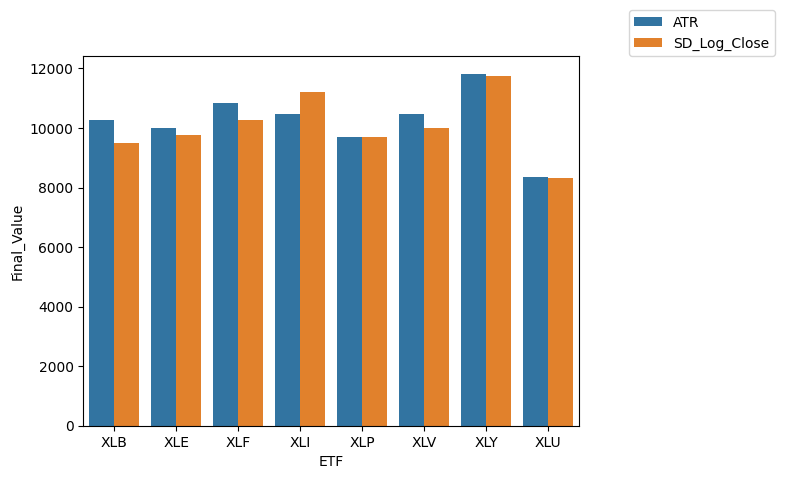

In [ ]:
fig2,ax = plt.subplots()
sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax)
plt.legend(loc=(1.1,1))
fig2.savefig('return_metrics.png')


In [ ]:
money_df_passive

,XLB_SD_Log_Close_Passive,XLE_SD_Log_Close_Passive,XLF_SD_Log_Close_Passive,XLI_SD_Log_Close_Passive,XLP_SD_Log_Close_Passive,XLV_SD_Log_Close_Passive,XLY_SD_Log_Close_Passive,XLU_SD_Log_Close_Passive
0,9969.403990,10009.430626,9905.529314,9968.479117,9941.144265,9915.641204,10010.309987,9883.477741
1,10014.686085,9865.613580,9924.979161,9945.823483,9859.019984,9842.117483,10003.436662,9710.188228
2,10093.011871,10060.120240,9891.636566,9985.224586,9786.476868,9825.864871,9877.654822,9550.343591
3,10208.052870,10148.532359,9844.401223,10102.442868,9920.613195,9886.231716,9844.662863,9731.102480
4,10353.689879,10286.455263,10000.000000,10211.780930,9928.825623,9996.904264,10056.361262,9896.922617
...,...,...,...,...,...,...,...,...
210,10550.728185,10058.941412,10450.125035,11239.164697,9834.382699,10516.987849,12431.094921,9405.437705
211,10510.341451,9905.693740,10480.689080,11242.119779,9838.488913,10544.075536,12366.485669,9472.662085
212,10468.730877,9883.296004,10447.346485,11228.329393,9859.019984,10554.910611,12290.191766,9460.711085
213,10450.373271,9989.390546,10491.803279,11115.051221,9969.887763,10740.654748,12176.094577,9598.147595


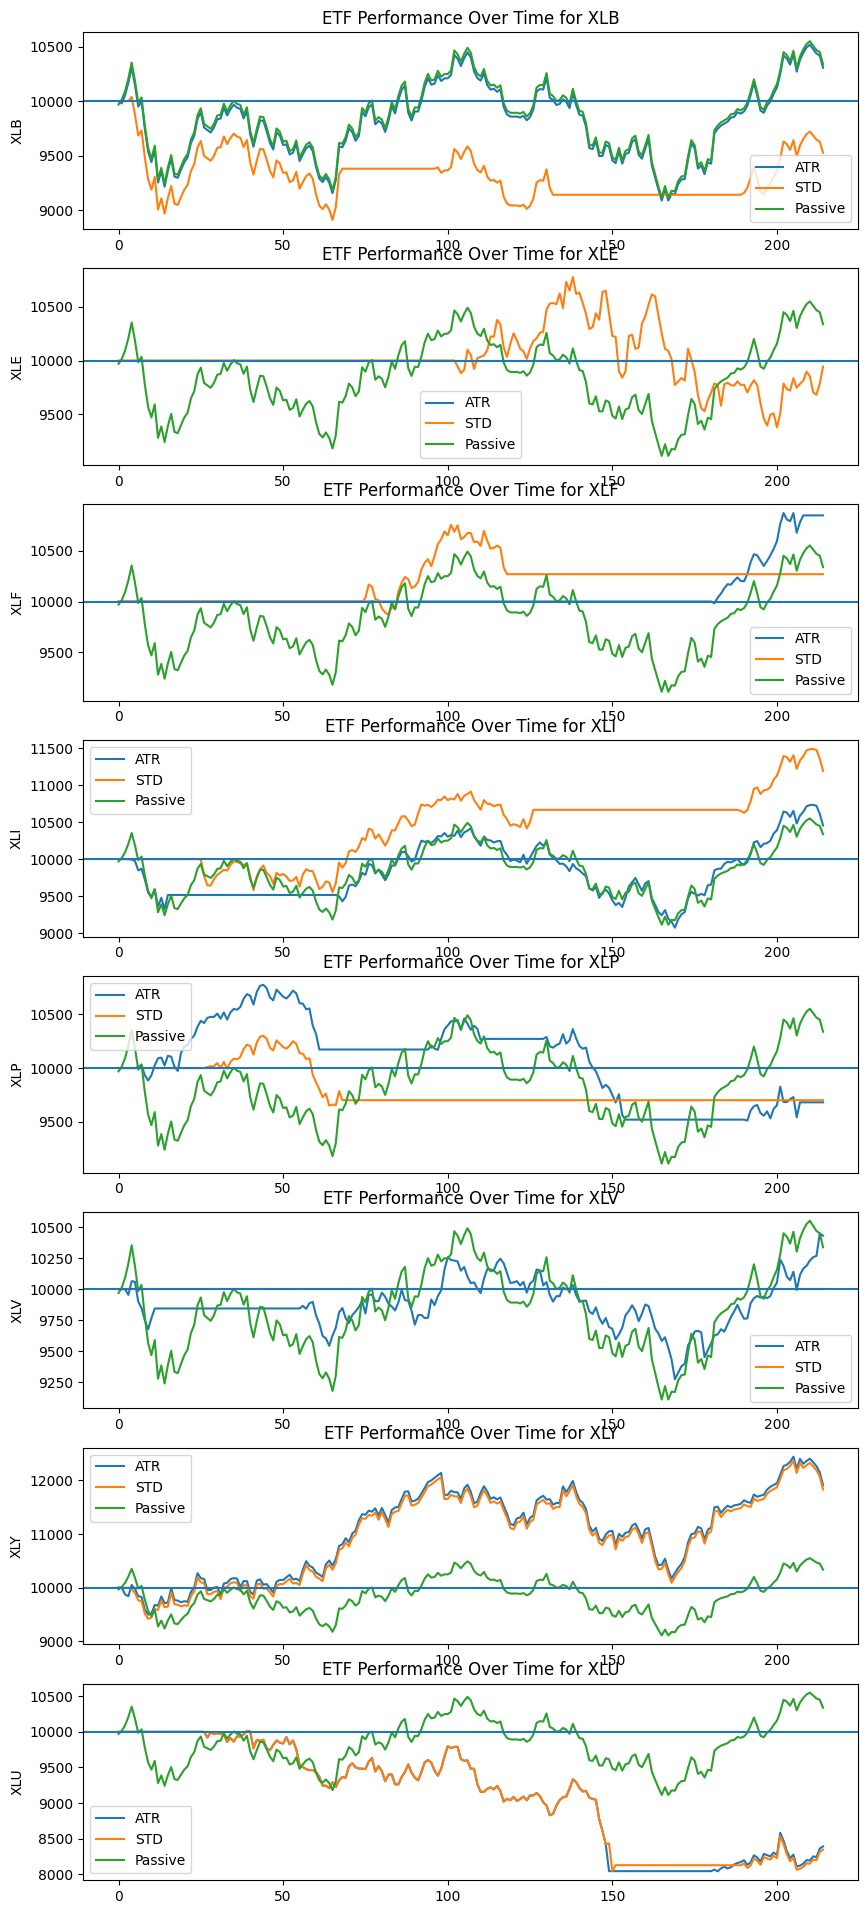

In [ ]:
fig3,ax = plt.subplots(len(etfs),1,figsize=(10,24))


for i,etf in enumerate(money_df_atr.columns):
    sns.lineplot(x=range(0, 215), y=money_df_atr[etf], label="ATR", ax=ax[i])
    sns.lineplot(x=range(0,215),y=money_df_std[etf],label="STD",ax=ax[i])
    sns.lineplot(x=range(0,215),y=money_df_passive[f"XLB_SD_Log_Close_Passive"],label="Passive",ax=ax[i])
    ax[i].axhline(10000)
    ax[i].set_title(f"ETF Performance Over Time for {etf}")
plt.legend()  
plt.show()
      




In [ ]:
money_df = pd.DataFrame()

money_df['xlb'] = [5,6,7]